## Gait Video Study 
### Validating the estimates 3D poses via CoP computed on the treadmill 
### This code qualitatively and quantitatively validates the center of mass trajectory of estimates body coordinates with their respective treadmill extracted CoP's on a frame by frame basis

We will do qualitative and quantitative validation for CoP. 
* First, we need to align the treadmill GaitCycles.csv file to the video time. This will help us align the corresponding video frames to the gait events i.e. HSR/HSL/TOR and TOL to be specific. 
* Once we know for each video, which frame numbers correspond to heel strikes and toe offs, we compute the sequence of frames that are in single support left phase, frames that are in single support right phase and similarly in double support phase. Thus, each frame of a video is labelled to be in SSR, SSL or DS phase. 
* Now, for each frame in DS phase, use the computed real world x, y coordinates for big toe, small toe and heel to make 2 triangular regions for both left and right feet, since in this phase, both feet are on ground and thus impact the center of pressure. Now, plot the corresponding actual COPX, COPY coordinate (as a red dot) for this particular frame. If this red dot lies in the shaded region of computed CoP drawn, we are good to claim that actual CoP lies in the approximate computed CoP region. Similarly, for each frame in the SSL phase, since left foot rests on ground for this phase, the CoP must be determined using the left foot, and hence use the computed x, y coordinates of the left big toe, small toe and heel to draw a shaded triangular region spanned by CoP for this frame, and draw the red dot for the actual x, y of CoP for this frame and if it lies within the shaded region, we are good to claim that actual and computed CoP region match. Now, for each frame in SSR phase, the shaded CoP region must be determined using the right feet's big/small toe and heel's x, y coordinates and if the actual CoP's x, y is bounded in this shaded computed CoP's region, we are good. 

* For qualitative validation, we plot these above mentioned regions for computed CoP and actual CoPs as markers in/out of that region for each video. If we do this for a complete stride, it should follow a butterfly pattern. And hence the inverted triangles and hexagons should occur in a butterfly pattern.
* For quantitative validation, we will call it success (1) if the actual CoP is bounded by the computed CoP shaded region and failure (0) otherwise for every frame of every video for every trial and cohort. 
* Further, for more precise quantitative validation, we can find the lateral, anterior-posterior and euclidean distance of the actual (COP_x, COP_y) with the centroid of our region drawn. This gives us a numerical value quantifying the error in the true and predicted CoP. This step can especially be done for only wrongly predicted values, to further check what is the measure of wrongly predicted values. Further, we may check that we may have error most in the lateral direction or most in the AP direction or eucliean only. 
* Based on the statistics of these success and failure counts, we can quantify the performance of our marker estimation framework using CoP validation. 
* Further, we can try to correlate/have a look at the distribution pattern to relate the correctness of CoP (either quantified using binary scores or using the numerical scores) with the confidence scores predicted by the OpenPose algorithm. Now, since we are only using toes and heel coordinates to draw the CoM trajectory/region, we should only use the confidence scores for heel and toes for this correlation. To be precise, we can average the confidence scores of left feet's heel and 2 toes to get the aggregated confidence score for frames in left single support, similarly, we can average the confidence scores of right feet's heel and 2 toes to get the aggregated confidence score for frames in right single support, and average the confidence scores of both the left and right feet's heel and toes to get the aggregated confidence scores for frames in double support. Now this correlation/relation between the confidence score for each frame and it's coorsponding correctness of CoP metric can be either done on a frame by frame basis. Or rather we can aggreagte all frames over a stride and do the relationship analysis on a stride by stride basis based on some aggregatd confidence scores of stride with some aggregated correctness of CoP score over each stride. 

In [1]:
from importlib import reload
from ml_utils import imports 
reload(imports)
from ml_utils.imports import *
from shapely.geometry.polygon import Polygon
from shapely.geometry import asPolygon, asPoint, asMultiPoint #Shapely helps find centroid of polygons 
import geopandas as gpd #For plotting shapely objects 

In [2]:
#Folder for CoP validation
cop_path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\CoPvalidation\\'
#Path to store the new dataframes to be created for CoP validation 
path_viz_dataframes = cop_path + 'CoP_dataframes_for_viz\\'
#Path for CoP validation dataframes without hip height normalization
path_viz_dataframes_non_normalized = path_viz_dataframes+'non_hip_height_normalized\\'
#Path to log file corresponding to the sync files between frame numbers and treadmill identified events for each video
sync_log_file = cop_path + 'treamill_video_cop_sync.csv'

#Path to save the vizualization plots 
save_viz_path = cop_path+'CoPviz_plots\\'

coordinate_cols = ['left toe 1-x', 'left toe 1-y', 'left toe 1-conf', 'left toe 2-x', \
                      'left toe 2-y', 'left toe 2-conf', 'left heel-x', 'left heel-y', 'left heel-conf', 'right toe 1-x', 'right toe 1-y',\
                       'right toe 1-conf', 'right toe 2-x', 'right toe 2-y', 'right toe 2-conf', 'right heel-x', 'right heel-y', \
                       'right heel-conf']
coordinate_cols_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'right toe 1-x', 'right toe 2-x', 'right heel-x']
coordinate_cols_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'right toe 1-y', 'right toe 2-y', 'right heel-y']

### Utility functions

In [3]:
def is_point_in_path(x: int, y: int, poly) -> bool:
    """
    Determine if the point is in the path.
    References: 
        https://wrf.ecse.rpi.edu//Research/Short_Notes/pnpoly.html
        https://en.wikipedia.org/wiki/Even%E2%80%93odd_rule
    Args:
      x -- The x coordinates of point.
      y -- The y coordinates of point.
      poly -- a list of tuples [(x, y), (x, y), ...]

    Returns:
      True if the point is in the path.
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                  (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [4]:
def distances(centroid, treadmill_cop):
    '''
    For the true (COPX, COPY) and computed base of support's (centroid_x, centroid_y), we compute the euclidean,
    lateral and anterior-posterior distances between them 
    Arguments:
        centroid: centroid_x, centroid_y for the BoS
        treadmill_cop: COPX, COPY
    Returns:
        euclidean_dist, lateral_dist, anterior_posterior_dist: Euclidean, lateral and AP distances between the centroid and CoP        

    '''
    euclidean_dist = np.linalg.norm(centroid - treadmill_cop)
    lateral_dist = centroid[0] - treadmill_cop[0] #Raw difference between x axis (We may need to use absolute values for results)
    anterior_posterior_dist = centroid[1] - treadmill_cop[1] #Raw difference between y axis (We may need to use absolute values for results)
    return euclidean_dist, lateral_dist, anterior_posterior_dist

In [5]:
def plot(viz_file, video, bool_frame_wise = True, non_normalized = False):
    '''
    To plot the traingles and hexagons for BoS and true treadmill CoPs each frame or each valid support group in each 
    valid stride of one video given by viz_file all on the same plot
    Arguments:
        viz_file: File containing either frame-wise CoPs and coordinates for all strides of a particular video or support 
        group-wise CoP and coordinates for a particular video
        
        video: video name for which we are plotting either frame-wise or support group-wise BoSs (with their centroid) 
        and true CoPs 
        
        bool_frame_wise: True if plot needs to be done over frames of the video and False if plot needs to done 
        over support groups of the video
        
        non_normalized: True/False depending on whether the 3D body coordinates we are using are normalized by 
        hip height being scaled to 100 (as we do before feeding them to models for size-normalization) or not 
        For our case, non-normalized versions (True) are better since our true treadmill CoPs are non-normalized and thus the 
        body coordinates too should be non-normalized 
    
    Plots the triangular and hexagonal BoSs for each frame/support group and saves them to save_viz_path
    '''
    plt.figure(figsize = (10, 10))
    #For each frame/support group in each stride of the video 
    for i in range(len(viz_file)):
        viz_file_index = viz_file.iloc[i]
        #Define x-y coordinates based on the support type of either a single frame or a support group
        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
        #Plotting the BoS area 
        plt.plot(x, y, '*--')
        #Plotting the true treadmill's CoP
        plt.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], '*')
    #Saving the single plot for with all true CoPs and estimated BoS regions for each video to save_viz_path with appropriate 
    #tag depending on whether it was constructed using hip-height normalized body coordinates or non-normalized 
    if bool_frame_wise: #For saving frame-wise 
        folder = 'frame_wise_full_video\\'
    else: #For saving support group wise 
        folder = 'support_group_wise_full_video\\'
    if non_normalized:
        plt.savefig(save_viz_path+ folder + video+'_non_normalized.png', dpi = 300)
    else:
        plt.savefig(save_viz_path+ folder + video+'.png', dpi = 300)
    #     plt.show()

In [6]:
def save_all_video_plots(bool_frame_wise = True, non_normalized = False):
    '''
    Function to save the plots (one for each video) for all videos in trials W and WT. Each plot for one video will consist of 
    traingles and hexagons for BoS and true treadmill CoPs for each frame or each valid support group in each 
    valid stride of one video given by viz_file (all on the same plot).
    Whether this function uses individual frames or support groups depends on whether we use viz_file/viz_file_grouped respectively
    for the plot function 
    Further this function either uses the hip-height normalized or non-normalized body coordinates to compute the BoS 
    either frame-wise or support group wise
    
    Arguments:
        bool_frame_wise: True if plot needs to be done over frames of the video and False if plot needs to done 
        over support groups of the video
        
        non_normalized: True/False depending on whether the 3D body coordinates we are using are normalized by 
        hip height being scaled to 100 (as we do before feeding them to models for size-normalization) or not 
        For our case, non-normalized versions (True) are better since our true treadmill CoPs are non-normalized and thus the 
        body coordinates too should be non-normalized 
    
    Plots the triangular and hexagonal BoSs for each frame/support group and saves them to save_viz_path for each video 
    of trial W and trial WT
    '''
    #Trial W
    for idx in range(len(sync_log_trialW)):
        index = sync_log_trialW.iloc[idx]
        video = index['video']
        #Frame wise vizualization file for each video
        if not non_normalized: #Hip-height normalized version 
            viz_file = pd.read_csv(path_viz_dataframes+video+'.csv', index_col = 0)
        else: #Non-hip height normalized version (works better for our case)
            viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
        #Grouped by support type 
        if not non_normalized: #Hip-height normalized version 
            viz_file_grouped = pd.read_csv(path_viz_dataframes+video+'_grouped_by_support_type.csv', index_col = 0)
        else: #Non-hip height normalized version (works better for our case)
            viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
    #     display(viz_file.head())   
        if bool_frame_wise:
            plot(viz_file, video, bool_frame_wise, non_normalized)
        else:
            plot(viz_file_grouped, video, bool_frame_wise, non_normalized) 
    #     break

    #Trial WT 
    for idx in range(len(sync_log_trialWT)):
        index = sync_log_trialWT.iloc[idx]
        video = index['video']
        #Frame wise vizualization file for each video
        if not non_normalized: #Hip-height normalized version 
            viz_file = pd.read_csv(path_viz_dataframes+video+'.csv', index_col = 0)
        else: #Non-hip height normalized version (works better for our case)
            viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
        #Grouped by support type 
        if not non_normalized: #Hip-height normalized version 
            viz_file_grouped = pd.read_csv(path_viz_dataframes+video+'_grouped_by_support_type.csv', index_col = 0)
        else: #Non-hip height normalized version (works better for our case)
            viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
    #     display(viz_file.head())
        if bool_frame_wise:
            plot(viz_file, video, bool_frame_wise, non_normalized)
        else:
            plot(viz_file_grouped, video, bool_frame_wise, non_normalized) 
    #     break

In [7]:
def compute_OpenPose_treadmill_shift(viz_file_grouped, video):
    '''
    Function to create a dataframe to compute shift values between COPx, centroid_x and COPy, centroid_y for the current video 
    Basically, it eliminates the centroids of frames/support group types for which centroid lie outside the polygon and thus
    are invalid. If the computed centroid is not genuine, we keep centroid as NaN and drop the respective row later from analysis 
    to avoid outlier errors in computing the shift value or quantitative errors between centroid and treadmill's COP
    
    Arguments:
        viz_file_grouped: File containing either frame-wise CoPs and coordinates for all strides of a particular video or support 
        group-wise CoP and coordinates for a particular video
        
        video: video name for which we are plotting either frame-wise or support group-wise BoSs (with their centroid) 
        and true CoPs 
    Returns: 
        viz_file_grouped_for_shift: viz_file_grouped with valid centroids retained to compute the shift between centroid and treadmill CoP
    '''
    viz_file_grouped_for_shift = copy.deepcopy(viz_file_grouped)
    viz_file_grouped_for_shift['centroid_x'] = np.nan
    viz_file_grouped_for_shift['centroid_y'] = np.nan
    for i in range(len(viz_file_grouped_for_shift)):
        viz_file_index = viz_file_grouped_for_shift.iloc[i]
        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
        poly_xy = [(x_, y_) for x_, y_ in zip(x, y)]
        p = asPolygon(poly_xy)
        p_centroid = p.centroid
        p_centroid_x = np.array(p_centroid)[0]
        p_centroid_y = np.array(p_centroid)[1]
        #Checking if the computed centroid is genuine and lies inside the polygon
        #If the computed centroid is not genuine, we keep centroid as NaN and drop the respective row later from analysis 
        #to avoid outlier errors in computing the shift value or quantitative errors between centroid and treadmill's COP
        centroid_inside = is_point_in_path(p_centroid_x, p_centroid_y, poly_xy)
        if centroid_inside:
            viz_file_grouped_for_shift['centroid_x'].iloc[i] = p_centroid_x
            viz_file_grouped_for_shift['centroid_y'].iloc[i] = p_centroid_y
    #Deleting the rows with centroids lying outside the polygon shape 
    viz_file_grouped_for_shift.drop(viz_file_grouped_for_shift[viz_file_grouped_for_shift[['centroid_x', 'centroid_y']].isna().any(axis = 1)].index, inplace = True)
    return viz_file_grouped_for_shift

In [8]:
def create_groupwise_shift_dataframe():
    '''
    Function to create a dataframe with shift values between COPx, centroid_x and COPy, centroid_y for all videos with
    support phase wise grouped COPs and centroids 
    Returns: 
        shift: The dataframe with shift values between support group wise COPs and centroids for all videos in trial W and WT
    '''
    #Dataframe with x/y shift values for each video in trial W and WT 
    shift = pd.DataFrame (columns = ['video_name', 'median_diff_x', 'median_diff_y'])
    for idx in range(len(sync_log_trialW)):
        index = sync_log_trialW.iloc[idx]
        video = index['video']
        print (video)
        #Grouped viz file by support type
        viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
        #Handle NaNs in viz_file for support groups with body coordinates not detected by OpenPose 
        viz_file_grouped = viz_file_grouped.iloc[viz_file_grouped[coordinate_cols].dropna().index]
        #Uses the function that retains only valid centroids for shift computation 
        viz_file_grouped_for_shift = compute_OpenPose_treadmill_shift(viz_file_grouped, video)
        diff_x = viz_file_grouped_for_shift.treadmill_COP_x - viz_file_grouped_for_shift.centroid_x
    #     display (diff_x.describe())

        diff_y = viz_file_grouped_for_shift.treadmill_COP_y - viz_file_grouped_for_shift.centroid_y
    #     display (diff_y.describe())
        shift.loc[len(shift)] = [video, diff_x.median(), diff_y.median()]
        
    for idx in range(len(sync_log_trialWT)):
        index = sync_log_trialWT.iloc[idx]
        video = index['video']
        print (video)
        #Grouped viz file by support type
        viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
        #Handle NaNs in viz_file for support groups with body coordinates not detected by OpenPose 
        viz_file_grouped = viz_file_grouped.iloc[viz_file_grouped[coordinate_cols].dropna().index]
        viz_file_grouped_for_shift = compute_OpenPose_treadmill_shift(viz_file_grouped, video)
        diff_x = viz_file_grouped_for_shift.treadmill_COP_x - viz_file_grouped_for_shift.centroid_x
    #     display (diff_x.describe())

        diff_y = viz_file_grouped_for_shift.treadmill_COP_y - viz_file_grouped_for_shift.centroid_y
    #     display (diff_y.describe())
        shift.loc[len(shift)] = [video, diff_x.median(), diff_y.median()]
    return shift

In [9]:
def compute_stats(eucl_dist_list_ss, lat_dist_list_ss, ap_dist_list_ss, eucl_dist_list_ds, lat_dist_list_ds, ap_dist_list_ds, \
                 cop_x_ss, centroid_x_ss, cop_x_ds, centroid_x_ds, cop_y_ss, centroid_y_ss, cop_y_ds, centroid_y_ds, \
                conf_ss, conf_ds, ds_count):
    ''''
    Function to return the list of all information for the current video to use in the dataframe to analyze for Single/Double Support 
    phase i.e. mean and standard deviation of eucl., lateral, and AP distances; 
    Pearson/Spearman correlation and p-value for CoP and centroid; Pearson/Spearman correlation and p-value for eucl./lat/AP distances 
    and confidences; count of valid support phases used and count of strides used. 
    
    Arguments: 
    eucl_dist_list_ss, lat_dist_list_ss, ap_dist_list_ss: List for single support phase (SS) distanaces for the current video 
    eucl_dist_list_ds, lat_dist_list_ds, ap_dist_list_ds: List of double support phase (DS) distances for the current video 
    cop_x_ss, cop_y_ss, centroid_x_ss, centroid_y_ss: List of single support phase (SS) CoPs and centroids for correlation 
    cop_x_ds, cop_y_ds, centroid_x_ds, centroid_y_ds: List of double support phase (DS) CoPs and centroids for correlation   
    conf_ss: List for single support phase (SS) confidences 
    conf_ds: List for double support phase (DS) confidences 
    ds_count: Count for double support phases. This divide by 2 gives the count of valid strides we did validation for in the current video

    Returns:
        info_list_ss: List of all information for the current video to use in the dataframe to analyze for Single Support phase i.e. mean and 
        standard deviation of eucl., lateral, and AP distances; Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman
        correlation and p-value for eucl./lat/AP distances and confidences; count of valid support phases used and count of strides used. 
        
        info_list_ds: List of all information for the current video to use in the dataframe to analyze for Double Support phase i.e. mean and 
        standard deviation of eucl., lateral, and AP distances; Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman
        correlation and p-value for eucl./lat/AP distances and confidences; count of valid support phases used and count of strides used. 
    '''
    #Mean distances in single and double support phases for the current video 
    mean_eucl_ss, mean_lat_ss, mean_ap_ss = np.mean(eucl_dist_list_ss), np.mean(lat_dist_list_ss), np.mean(ap_dist_list_ss)
    mean_eucl_ds, mean_lat_ds, mean_ap_ds = np.mean(eucl_dist_list_ds), np.mean(lat_dist_list_ds), np.mean(ap_dist_list_ds)
    print ('Average euclidean, lateral and AP distance from centroid in cm (for single support type): ', mean_eucl_ss, mean_lat_ss, mean_ap_ss)
    print ('Average euclidean, lateral and AP distance from centroid in cm (for double support type): ', mean_eucl_ds, mean_lat_ds, mean_ap_ds)

    #Standard deviation in distances in single and double support phases for the current video 
    std_eucl_ss, std_lat_ss, std_ap_ss = np.std(eucl_dist_list_ss), np.std(lat_dist_list_ss), np.std(ap_dist_list_ss)
    std_eucl_ds, std_lat_ds, std_ap_ds = np.std(eucl_dist_list_ds), np.std(lat_dist_list_ds), np.std(ap_dist_list_ds)
    print ('Standard deviation in euclidean, lateral and AP distance from centroid in cm (for single support type): ', std_eucl_ss, std_lat_ss, std_ap_ss)
    print ('Standard deviation in euclidean, lateral and AP distance from centroid in cm (for double support type): ', std_eucl_ds, std_lat_ds, std_ap_ds)

    #Pearson Correlations between CoPX, centroidX and CoPY, centroidY
    pearson_corr_copx_centroidx_ss, pearson_p_copx_centroidx_ss = stats.pearsonr(cop_x_ss, centroid_x_ss)
    print ('Pearson correlation and p-value between CoPX and centroidX (for single suppprt type): ', pearson_corr_copx_centroidx_ss, \
           pearson_p_copx_centroidx_ss)
    pearson_corr_copx_centroidx_ds, pearson_p_copx_centroidx_ds = stats.pearsonr(cop_x_ds, centroid_x_ds)
    print ('Pearson correlation and p-value between CoPX and centroidX (for double suppprt type): ', pearson_corr_copx_centroidx_ds, \
           pearson_p_copx_centroidx_ds)    
    pearson_corr_copy_centroidy_ss, pearson_p_copy_centroidy_ss = stats.pearsonr(cop_y_ss, centroid_y_ss)
    print ('Pearson correlation and p-value between CoPY and centroidY (for single suppprt type): ', pearson_corr_copy_centroidy_ss, \
           pearson_p_copy_centroidy_ss)
    pearson_corr_copy_centroidy_ds, pearson_p_copy_centroidy_ds = stats.pearsonr(cop_y_ds, centroid_y_ds)
    print ('Pearson correlation and p-value between CoPY and centroidY (for double suppprt type): ', pearson_corr_copy_centroidy_ds, \
           pearson_p_copy_centroidy_ds)   
    
    #Spearman Correlations between CoPX, centroidX and CoPY, centroidY
    spearman_corr_copx_centroidx_ss, spearman_p_copx_centroidx_ss = stats.spearmanr(cop_x_ss, centroid_x_ss)
    print ('Spearman correlation and p-value between CoPX and centroidX (for single suppprt type): ', spearman_corr_copx_centroidx_ss, \
           spearman_p_copx_centroidx_ss)
    spearman_corr_copx_centroidx_ds, spearman_p_copx_centroidx_ds = stats.spearmanr(cop_x_ds, centroid_x_ds)
    print ('Spearman correlation and p-value between CoPX and centroidX (for double suppprt type): ', spearman_corr_copx_centroidx_ds, \
           spearman_p_copx_centroidx_ds)    
    spearman_corr_copy_centroidy_ss, spearman_p_copy_centroidy_ss = stats.spearmanr(cop_y_ss, centroid_y_ss)
    print ('Spearman correlation and p-value between CoPY and centroidY (for single suppprt type): ', spearman_corr_copy_centroidy_ss, \
           spearman_p_copy_centroidy_ss)
    spearman_corr_copy_centroidy_ds, spearman_p_copy_centroidy_ds = stats.spearmanr(cop_y_ds, centroid_y_ds)
    print ('Spearman correlation and p-value between CoPY and centroidY (for double suppprt type): ', spearman_corr_copy_centroidy_ds, \
           spearman_p_copy_centroidy_ds)  
    
    #Pearson correlations between the distances and confidence
    #Euclidean distance 
    pearson_corr_eucl_conf_ss, pearson_p_eucl_conf_ss = stats.pearsonr(conf_ss, eucl_dist_list_ss)
    print ('Pearson correlation and p-value between euclidean distance and confidence (for single suppprt type): ', pearson_corr_eucl_conf_ss, \
           pearson_p_eucl_conf_ss)    
    pearson_corr_eucl_conf_ds, pearson_p_eucl_conf_ds = stats.pearsonr(conf_ds, eucl_dist_list_ds)
    print ('Pearson correlation and p-value between euclidean distance and confidence (for double suppprt type): ', pearson_corr_eucl_conf_ds, \
           pearson_p_eucl_conf_ds)   
    #Lateral distance 
    pearson_corr_lat_conf_ss, pearson_p_lat_conf_ss = stats.pearsonr(conf_ss, lat_dist_list_ss)
    print ('Pearson correlation and p-value between lateral distance and confidence (for single suppprt type): ', pearson_corr_lat_conf_ss, \
           pearson_p_lat_conf_ss)    
    pearson_corr_lat_conf_ds, pearson_p_lat_conf_ds = stats.pearsonr(conf_ds, lat_dist_list_ds)
    print ('Pearson correlation and p-value between lateral distance and confidence (for double suppprt type): ', pearson_corr_lat_conf_ds, \
           pearson_p_lat_conf_ds)    
    #AP distance 
    pearson_corr_ap_conf_ss, pearson_p_ap_conf_ss = stats.pearsonr(conf_ss, ap_dist_list_ss)
    print ('Pearson correlation and p-value between AP distance and confidence (for single suppprt type): ', pearson_corr_ap_conf_ss, \
           pearson_p_ap_conf_ss)    
    pearson_corr_ap_conf_ds, pearson_p_ap_conf_ds = stats.pearsonr(conf_ds, ap_dist_list_ds)
    print ('Pearson correlation and p-value between AP distance and confidence (for double suppprt type): ', pearson_corr_ap_conf_ds, \
           pearson_p_ap_conf_ds)     
  
    #Spearman correlations between the distances and confidence
    #Euclidean distance 
    spearman_corr_eucl_conf_ss, spearman_p_eucl_conf_ss = stats.spearmanr(conf_ss, eucl_dist_list_ss)
    print ('Spearman correlation and p-value between euclidean distance and confidence (for single suppprt type): ', spearman_corr_eucl_conf_ss, \
           spearman_p_eucl_conf_ss)    
    spearman_corr_eucl_conf_ds, spearman_p_eucl_conf_ds = stats.spearmanr(conf_ds, eucl_dist_list_ds)
    print ('Spearman correlation and p-value between euclidean distance and confidence (for double suppprt type): ', spearman_corr_eucl_conf_ds, \
           spearman_p_eucl_conf_ds)   
    #Lateral distance
    spearman_corr_lat_conf_ss, spearman_p_lat_conf_ss = stats.spearmanr(conf_ss, lat_dist_list_ss)
    print ('Spearman correlation and p-value between lateral distance and confidence (for single suppprt type): ', spearman_corr_lat_conf_ss, \
           spearman_p_lat_conf_ss)    
    spearman_corr_lat_conf_ds, spearman_p_lat_conf_ds = stats.spearmanr(conf_ds, lat_dist_list_ds)
    print ('Spearman correlation and p-value between lateral distance and confidence (for double suppprt type): ', spearman_corr_lat_conf_ds, \
           spearman_p_lat_conf_ds)    
    #AP distance 
    spearman_corr_ap_conf_ss, spearman_p_ap_conf_ss = stats.spearmanr(conf_ss, ap_dist_list_ss)
    print ('Spearman correlation and p-value between AP distance and confidence (for single suppprt type): ', spearman_corr_ap_conf_ss, \
           spearman_p_ap_conf_ss)    
    spearman_corr_ap_conf_ds, spearman_p_ap_conf_ds = stats.spearmanr(conf_ds, ap_dist_list_ds)
    print ('Spearman correlation and p-value between AP distance and confidence (for double suppprt type): ', spearman_corr_ap_conf_ds, \
           spearman_p_ap_conf_ds) 
    
    #Stats 
    #Count of valid single support and double support phases we used in this validation analysis for current video 
    count_ss_phases, count_ds_phases = len(eucl_dist_list_ss), len(eucl_dist_list_ds)
    print ('Count of valid single and double support phases used in validation for this video: ', count_ss_phases, count_ds_phases)
    #Count of valid strides we used in this validation analysis for current video 
    count_strides = ds_count/2
    print ('Count of valid strides used in validation for this video: ', count_strides)
    
    #Making a list of all information for the current video to use in the dataframe to analyze for SS and DS phases 
    #Single support 
    info_list_ss = [mean_eucl_ss, mean_lat_ss, mean_ap_ss, std_eucl_ss, std_lat_ss, std_ap_ss, pearson_corr_copx_centroidx_ss, pearson_p_copx_centroidx_ss,\
                   pearson_corr_copy_centroidy_ss, pearson_p_copy_centroidy_ss,  spearman_corr_copx_centroidx_ss, spearman_p_copx_centroidx_ss, \
                    spearman_corr_copy_centroidy_ss, spearman_p_copy_centroidy_ss, pearson_corr_eucl_conf_ss, pearson_p_eucl_conf_ss,\
                    pearson_corr_lat_conf_ss, pearson_p_lat_conf_ss, pearson_corr_ap_conf_ss, pearson_p_ap_conf_ss, \
                    spearman_corr_eucl_conf_ds, spearman_p_eucl_conf_ds, spearman_corr_lat_conf_ss, spearman_p_lat_conf_ss, \
                    spearman_corr_ap_conf_ss, spearman_p_ap_conf_ss, count_ss_phases, count_strides]
    #Double support 
    info_list_ds = [mean_eucl_ds, mean_lat_ds, mean_ap_ds, std_eucl_ds, std_lat_ds, std_ap_ds, pearson_corr_copx_centroidx_ds, pearson_p_copx_centroidx_ds, \
                 pearson_corr_copy_centroidy_ds, pearson_p_copy_centroidy_ds, spearman_corr_copx_centroidx_ds, spearman_p_copx_centroidx_ds, \
                spearman_corr_copy_centroidy_ds, spearman_p_copy_centroidy_ds, pearson_corr_eucl_conf_ds, pearson_p_eucl_conf_ds, \
                pearson_corr_lat_conf_ds, pearson_p_lat_conf_ds, pearson_corr_ap_conf_ds, pearson_p_ap_conf_ds, \
                spearman_corr_eucl_conf_ds, spearman_p_eucl_conf_ds, spearman_corr_lat_conf_ds, spearman_p_lat_conf_ds,  \
                    spearman_corr_ap_conf_ds, spearman_p_ap_conf_ds, count_ds_phases, count_strides]

# #         Absolute lateral and anterior-posterior distance 
#         lat_dist_list_abs = list(map(abs, lat_dist_list))
#         ap_dist_list_abs = list(map(abs, ap_dist_list))
#         print ('Average absolute lateral and AP distance from centroid in cm: ', np.mean(lat_dist_list_abs), \
#            np.mean(ap_dist_list_abs))
#         print ('Standard deviation of absolute lateral and AP distance from centroid in cm: ', np.std(lat_dist_list_abs), \
#            np.std(ap_dist_list_abs))  

    return info_list_ss, info_list_ds

In [18]:
def plotBOS_compute_COPcentroid_distances(viz_file, video, non_normalized = False, bool_frame_wise = True, plot_bool = True, case = 'shift'):
    '''
    Function to plot the triangular or hexagonal BoS for each frame/support group and return the list of all information for the current video to 
    use in the dataframe to analyze for Single/Double Support phase i.e. mean and standard deviation of eucl., lateral, and AP distances; 
    Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman correlation and p-value for eucl./lat/AP distances 
    and confidences; count of valid support phases used and count of strides used. 
    
    Arguments:  
        viz_file: File containing either frame-wise CoPs and coordinates for all strides of a particular video or support 
        group-wise CoP and coordinates for a particular video
        
        video: video name for which we are plotting either frame-wise or support group-wise BoSs (with their centroid) 
        and true CoPs 
        
        non_normalized: True/False depending on whether the 3D body coordinates we are using are normalized by 
        hip height being scaled to 100 (as we do before feeding them to models for size-normalization) or not 
        For our case, non-normalized versions (True) are better since our true treadmill CoPs are non-normalized and thus the 
        body coordinates too should be non-normalized 
        
        bool_frame_wise: True if plot needs to be done over frames of the video and False if plot needs to done 
        over support groups of the video
        
        plot_bool: True if we wish to plot and save the individual frame-wise or support-group-wise traingles and hexagons 
        for the strides of current video (Note that  in this case, we have one plot per frame/support group)
        
        case: shift or excursion depending on which alignment method we use 
        
    Returns:
        info_list_ss: List of all information for the current video to use in the dataframe to analyze for Single Support phase i.e. mean and 
        standard deviation of eucl., lateral, and AP distances; Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman
        correlation and p-value for eucl./lat/AP distances and confidences; count of valid support phases used and count of strides used. 
        
        info_list_ds: List of all information for the current video to use in the dataframe to analyze for Double Support phase i.e. mean and 
        standard deviation of eucl., lateral, and AP distances; Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman
        correlation and p-value for eucl./lat/AP distances and confidences; count of valid support phases used and count of strides used. 
    '''
    #Check if there are any NaN coordinates 
#     print (viz_file[coordinate_cols].isna().any(axis = 1).sum())
    #Count of CoPs that lie inside the BoS polygon of body coordinates 
    count_inside = 0
    #Count of frames/support groups that have centroid of BoS inside the BoS polygon and thus are valid to be 
    #included in our analysis
    count_include_analysis = 0
    #Count for double support phases. This divide by 2 gives the count of valid strides we did validation for in the current video 
    ds_count = 0
    #List for single support phase (SS) distanaces for the current video 
    eucl_dist_list_ss, lat_dist_list_ss, ap_dist_list_ss = [], [], []
    #List of double support phase (DS) distances for the current video 
    eucl_dist_list_ds, lat_dist_list_ds, ap_dist_list_ds = [], [], []
    #List of single support phase (SS) CoPs and centroids for correlation 
    cop_x_ss, cop_y_ss, centroid_x_ss, centroid_y_ss = [], [], [], []
    #List of double support phase (DS) CoPs and centroids for correlation 
    cop_x_ds, cop_y_ds, centroid_x_ds, centroid_y_ds = [], [], [], []    
    #List for single support phase (SS) confidences 
    conf_ss = []
    #List for double support phase (DS) confidences 
    conf_ds = []  

    if case == 'shift': #If we used the shift method to align CoP and centroid 
        if bool_frame_wise:
            folder = '\\shift_frame_wise_viz\\'
        else:
            folder = '\\shift_support_group_wise_viz\\'
    if plot_bool:
        plot_distances_file = open(save_viz_path+folder+"plot_distances.txt","w") 
    
    colormap = np.array(['cornflowerblue', 'b', 'cyan'])
    #For the true butterfly diagram for the current stride 
#     HSR_indices = viz_file[viz_file.EventType=='HSR'].index
    
    for i in range(len(viz_file)):
        viz_file_index = viz_file.iloc[i]
        #For the true butterfly diagram for the current stride 
#         try:
#             stride_limits = range(HSR_indices[HSR_indices<=i][-1], HSR_indices[HSR_indices>i][0]+1)
#         except:
#             stride_limits = range(HSR_indices[HSR_indices<=i][-1], len(viz_file)) #For the last HSR 

        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
            conf = viz_file_index[both_foot_confidences]
            categories = np.array([0, 1, 2, 2, 1, 0])
            support = 'ds'
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
            conf = viz_file_index[right_foot_confidences]
            categories = np.array([0, 1, 2])
            support = 'ss'
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
            conf = viz_file_index[left_foot_confidences]
            categories = np.array([0, 1, 2])
            support = 'ss'
        poly_xy = [(x_, y_) for x_, y_ in zip(x, y)]
#         plt.figure()
#         plt.plot(x, y, '*--')    
        p = asPolygon(poly_xy)
        #For the true butterfly diagram for the current stride 
#         ax.plot(viz_file.iloc[stride_limits]['treadmill_COP_x'], viz_file.iloc[stride_limits]['treadmill_COP_y'], 'k-')
        p1 = gpd.GeoSeries(p)
        try:
            p_centroid = p.centroid
        
            p_centroid_x = np.array(p_centroid)[0]
            p_centroid_y = np.array(p_centroid)[1]
            #Checking if the computed centroid is genuine and lies inside the polygon
            #If the computed centroid is not genuine, we keep centroid as NaN and drop the respective row later from analysis 
            #to avoid outlier errors in computing the shift value or quantitative errors between centroid and treadmill's COP
            centroid_inside = is_point_in_path(p_centroid_x, p_centroid_y, poly_xy)
            if support == 'ds':
                ds_count+=1
            if centroid_inside:
                count_include_analysis +=1
                #If this is a valid centroid, we check if CoP ies inside the BoS region/polygon
                point_inside = is_point_in_path(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], poly_xy)
    #             print (viz_file_index.support_type, point_inside)
                if point_inside:
                    count_inside+=1 #Count for frames/support groups with CoPs inside the BoS region
                #Computing the euclidean, lateral and AP distances between the current centroid and CoP 
                eucl_dist, lat_dist, ap_dist = distances(np.array(p_centroid), viz_file.iloc[i][['treadmill_COP_x', 'treadmill_COP_y']].values)
                #Appending the distances to appropriate lists depending on the support group for the current frame/support group type 
                if support == 'ss':
                    #Appending the distances for SS
                    eucl_dist_list_ss.append(eucl_dist)
                    lat_dist_list_ss.append(lat_dist)
                    ap_dist_list_ss.append(ap_dist)
                    #Appending the CoPs and centroids for SS
                    centroid_x_ss.append(p_centroid_x)
                    centroid_y_ss.append(p_centroid_y)
                    cop_x_ss.append(viz_file.iloc[i]['treadmill_COP_x'])
                    cop_y_ss.append(viz_file.iloc[i]['treadmill_COP_y'])
                    #Appending the confidences for SS
                    conf_ss.append(conf.mean())

                if support == 'ds':
                    #Appending the distances for DS
                    eucl_dist_list_ds.append(eucl_dist)
                    lat_dist_list_ds.append(lat_dist)
                    ap_dist_list_ds.append(ap_dist)
                    #Appending the CoPs and centroids for DS
                    centroid_x_ds.append(p_centroid_x)
                    centroid_y_ds.append(p_centroid_y)
                    cop_x_ds.append(viz_file.iloc[i]['treadmill_COP_x'])
                    cop_y_ds.append(viz_file.iloc[i]['treadmill_COP_y'])
                    #Appending the confidences for DS
                    conf_ds.append(conf.mean())                

                if plot_bool: #True to plot the BoS with centroid and corresponding CoP 
                    fig, ax = plt.subplots(figsize = (15, 6))
                    p2 = gpd.GeoSeries(p_centroid)
                    p1.plot(edgecolor='black', color = 'aliceblue', ax= ax, linestyle = '--')
                    ax.scatter(p.exterior.xy[0][:-1], p.exterior.xy[1][:-1], marker = 'o', s = 50, linestyle = 'None', c = colormap[categories], edgecolor = 'grey')
                    p2.plot(ax = ax, color = 'lime', marker = 'X', markersize = 100, edgecolor = 'grey')
                    ax.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], 'r', marker = '*', markersize = 10)
                    plot_distances_file.write(video+'_non_normalized_' + str(i) + str(point_inside) + ' Euclidean, Lateral and AP distance from centroid (in cm): '\
                                               + str(eucl_dist) + ', ' + str(lat_dist) + ', ' + str(ap_dist) + '\n')

                    if non_normalized:
                        plt.savefig(save_viz_path+folder+video+'_non_normalized_' + str(i) + str(point_inside) + '.png', dpi = 300)
                    else:
                        plt.savefig(save_viz_path+folder+video+'_normalized_' + str(i) + str(point_inside) + '.png', dpi = 300)
                    plt.show()
        except:
            print (poly_xy)
#             print (p)
#             print (p1)
    if plot_bool:
        plot_distances_file.close()
    print ('No. of CoPs lying inside polygons are:', count_inside, ' out of ', count_include_analysis)
    #Function to compute all the stats and return them as lists 
    info_list_ss, info_list_ds = compute_stats(eucl_dist_list_ss, lat_dist_list_ss, ap_dist_list_ss, eucl_dist_list_ds, lat_dist_list_ds, ap_dist_list_ds, \
                 cop_x_ss, centroid_x_ss, cop_x_ds, centroid_x_ds, cop_y_ss, centroid_y_ss, cop_y_ds, centroid_y_ds, \
                conf_ss, conf_ds, ds_count)
    return info_list_ss, info_list_ds

In [19]:
def create_cop_verify_stats_dataframe(sync_log_trials_W_WT, shift, non_normalized_ = True, bool_frame_wise_= False, plot_bool_ = False, \
                                      case_ = 'shift'):
    '''
    Function to save all stats from trials W and WT using the shift method to a dataframe and .csv file 
    
    Arguments: 
        sync_log_trials_W_WT: File containing information about valid video files for trails W and WT to use in validation 
        
        shift: Dataframe with x/y shift of centroid and treadmill's CoP 
    
        non_normalized: True/False depending on whether the 3D body coordinates we are using are normalized by 
        hip height being scaled to 100 (as we do before feeding them to models for size-normalization) or not 
        For our case, non-normalized versions (True) are better since our true treadmill CoPs are non-normalized and thus the 
        body coordinates too should be non-normalized 
        
        bool_frame_wise: True if plot needs to be done over frames of the video and False if plot needs to done 
        over support groups of the video
        
        plot_bool: True if we wish to plot and save the individual frame-wise or support-group-wise traingles and hexagons 
        for the strides of current video (Note that  in this case, we have one plot per frame/support group)

        case: shift or excursion depending on which alignment method we use
    '''
    #Datagtame with all the information for the current video to analyze for Single Support phase i.e. mean and 
    #standard deviation of eucl., lateral, and AP distances; Pearson/Spearman correlattion and p-value for CoP and centroid; Pearson/Spearman
    #correlation and p-value for eucl./lat/AP distances and confidences; count of valid support phases used and count of strides used
    group_wise_cop_verify_stats_columns = ['cohort', 'scenario', 'video', 'suport_group', 'mean_eucl', 'mean_lat', 'mean_ap', 'std_eucl', \
                                          'std_lat', 'std_ap', 'pearson_corr_copx_centroidx', 'pearson_p_copx_centroidx', \
                                           'pearson_corr_copy_centroidy', 'pearson_p_copy_centroidy', 'spearman_corr_copx_centroidx', \
                                          'spearman_p_copx_centroidx', 'spearman_corr_copy_centroidy', 'spearman_p_copy_centroidy', \
                                            'pearson_corr_eucl_conf', 'pearson_p_eucl_conf', 'pearson_corr_lat_conf', 'pearson_p_lat_conf', \
                                          'pearson_corr_ap_conf', 'pearson_p_ap_conf', 'spearman_corr_eucl_conf', 'spearman_p_eucl_conf', \
                                          'spearman_corr_lat_conf', 'spearman_p_lat_conf', 'spearman_corr_ap_conf', 'spearman_p_ap_conf', \
                                          'count_support_phases', 'count_strides']
    group_wise_cop_verify_stats = pd.DataFrame(columns = group_wise_cop_verify_stats_columns)

    sync_log_trials_W_WT = pd.concat((sync_log_trialW, sync_log_trialWT))

    if not non_normalized_:
        viz_path = path_viz_dataframes
    else:
        viz_path = path_viz_dataframes_non_normalized
    
    for idx in range(len(sync_log_trials_W_WT)):
        index = sync_log_trials_W_WT.iloc[idx]
        video = index['video']
        cohort = index['cohort']
        scenario = index['scenario']

        print (video)
        #Frame wise vizualization file for each video
        viz_file = pd.read_csv(viz_path+video+'.csv', index_col = 0)
        #Handle NaNs in viz_file for frames with body coordinates not detected by OpenPose 
        viz_file= viz_file.iloc[viz_file[coordinate_cols].dropna().index]
        #Grouped viz file by support type
        viz_file_grouped = pd.read_csv(viz_path+video+'_grouped_by_support_type.csv', index_col = 0)

        if case_ == 'shift':
            #Applying the group wise shift to support wise grouped coordinates 
            viz_file_grouped[coordinate_cols_x]= viz_file_grouped[coordinate_cols_x]+shift[shift.video_name==video]['median_diff_x'].values[0]
            viz_file_grouped[coordinate_cols_y]= viz_file_grouped[coordinate_cols_y]+shift[shift.video_name==video]['median_diff_y'].values[0]

        if bool_frame_wise_:
            #Use viz_file arranged frame wise for bool_frame_wise = True
            info_ss, info_ds  = plotBOS_compute_COPcentroid_distances(viz_file, video, non_normalized = non_normalized_, bool_frame_wise = bool_frame_wise_, \
                                                  plot_bool = plot_bool_, case = case_)
        else:
            #Use viz_file_grouped arranged support group wise for bool_frame_wise = False
            info_ss, info_ds = plotBOS_compute_COPcentroid_distances(viz_file_grouped, video, non_normalized = non_normalized_, bool_frame_wise = bool_frame_wise_, \
                                                  plot_bool = plot_bool_, case = case_)

        group_wise_cop_verify_stats.loc[len(group_wise_cop_verify_stats)] = [cohort, scenario, video, 'SS'] + info_ss
        group_wise_cop_verify_stats.loc[len(group_wise_cop_verify_stats)] = [cohort, scenario, video, 'DS'] + info_ds

    #Saving all stats from trials W and WT using the shift method 
    group_wise_cop_verify_stats.to_csv(cop_path+'group_wise_cop_verify_stats_with_' + case_ + '_method.csv')

### main()

In [20]:
#We are going to do qualitative and quantitative analysis only for W and WT trials for this paper  
sync_log = pd.read_csv(sync_log_file, index_col = 0)
sync_log = sync_log[sync_log['Sync']=='Exists']

#Separating the videos by trial (W and WT)
sync_log_trialW = sync_log[sync_log.scenario == 'W']
sync_log_trialWT = sync_log[sync_log.scenario == 'WT']

#Videos for trials W and WT 
sync_log_trials_W_WT = pd.concat((sync_log_trialW, sync_log_trialWT))

In [21]:
%matplotlib inline

In [22]:
#Triangular region of the left foot
left_foot_coordinates_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'left toe 1-x'] 
left_foot_coordinates_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'left toe 1-y']
left_foot_confidences = ['left toe 1-conf', 'left toe 2-conf', 'left heel-conf']

#Triangular region of the right foot
right_foot_coordinates_x = ['right toe 1-x', 'right toe 2-x', 'right heel-x', 'right toe 1-x'] 
right_foot_coordinates_y =  ['right toe 1-y', 'right toe 2-y', 'right heel-y', 'right toe 1-y']
right_foot_confidences = ['right toe 1-conf', 'right toe 2-conf', 'right heel-conf']

#Hexagon of both feet together 
both_foot_coordinates_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'right heel-x', 'right toe 2-x', 'right toe 1-x', 'left toe 1-x'] 
both_foot_coordinates_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'right heel-y', 'right toe 2-y', 'right toe 1-y', 'left toe 1-y'] 
#Joining the big toe and heel of left and right feet in the hexagon to identify individual triangular feet as well 
both_foot_single_join_left_x = ['left toe 1-x', 'left heel-x']
both_foot_single_join_left_y = ['left toe 1-y', 'left heel-y']
both_foot_single_join_right_x = ['right toe 1-x', 'right heel-x']
both_foot_single_join_right_y = ['right toe 1-y', 'right heel-y']
both_foot_confidences = left_foot_confidences + right_foot_confidences

In [ ]:
#### Run once to save all plots  #######
#To plot and save the plots (one for each video) for all videos in trials W and WT. 
#Each plot for one video will consist of traingles and hexagons for BoS and true treadmill CoPs for each frame 
#or each valid support group in each valid stride of one video given by viz_file (all on the same plot)
#Saves in folder frame_wise_full_video or support_group_wise_full_video folders 
bool_frame_wise_ = True
non_normalized_ = True
save_all_video_plots(bool_frame_wise_, non_normalized_)

In [111]:
#### Run once to save the shift dataframe  #######
#Creating the centroid-CoP shift dataframe and saving as .csv 
shift = create_groupwise_shift_dataframe()
shift.to_csv(cop_path+'groupwise_shift_dataframe.csv')

GVS_212_W_T2
GVS_213_W_T1
GVS_214_W_T1
GVS_215_W_T1
GVS_216_W_T2
GVS_217_W_T1
GVS_218_W_T2
GVS_219_W_T2
GVS_310_W_T1
GVS_311_W_T1
GVS_312_W_T2
GVS_313_W_T1
GVS_314_W_T1
GVS_318_W_T1
GVS_320_W_T1
GVS_321_W_T1
GVS_322_W_T2
GVS_323_W_T1
GVS_404_W_T2
GVS_404_W_T3
GVS_405_W_T1
GVS_405_W_T3
GVS_406_W_T2
GVS_408_W_T2
GVS_409_W_T2
GVS_410_W_T1
GVS_411_W_T1
GVS_411_W_T3
GVS_102_W_T1
GVS_112_W_T1
GVS_113_W_T1
GVS_115_W_T1
GVS_123_W_T1
GVS_124_W_T1
GVS_212_W_T1
GVS_213_W_T2
GVS_214_W_T2
GVS_215_W_T2
GVS_216_W_T1
GVS_217_W_T2
GVS_218_W_T1
GVS_219_W_T1
GVS_310_W_T2
GVS_311_W_T2
GVS_313_W_T2
GVS_314_W_T2
GVS_318_W_T2
GVS_320_W_T2
GVS_321_W_T2
GVS_322_W_T1
GVS_323_W_T2
GVS_403_W_T2
GVS_404_W_T1
GVS_404_W_T4
GVS_405_W_T2
GVS_405_W_T4
GVS_406_W_T1
GVS_407_W_T1
GVS_408_W_T1
GVS_409_W_T1
GVS_410_W_T2
GVS_411_W_T2
GVS_411_W_T4


In [23]:
#Reading the shift dataframe from the saved file 
shift = pd.read_csv(cop_path+'groupwise_shift_dataframe.csv', index_col = 0)
shift.head()

,video_name,median_diff_x,median_diff_y
0,GVS_212_W_T2,9.209938,1.812395
1,GVS_213_W_T1,10.676478,2.002727
2,GVS_214_W_T1,10.114416,7.046648
3,GVS_215_W_T1,9.425297,6.728535
4,GVS_216_W_T2,8.727246,12.164225


In [ ]:
%matplotlib inline
create_cop_verify_stats_dataframe(sync_log_trials_W_WT, shift, non_normalized_ = True, bool_frame_wise_= False, plot_bool_ = False, case_ = 'shift')


GVS_212_W_T2
No. of CoPs lying inside polygons are: 106  out of  206
Average euclidean, lateral and AP distance from centroid in cm (for single support type):  5.99173856195849 0.5071903569749234 -2.2785869154568075
Average euclidean, lateral and AP distance from centroid in cm (for double support type):  6.543741355328107 0.3223386349595998 3.504041146489408
Standard deviation in euclidean, lateral and AP distance from centroid in cm (for single support type):  2.736198950971019 3.341651557856431 5.174155019955596
Standard deviation in euclidean, lateral and AP distance from centroid in cm (for double support type):  3.9641686268733265 1.967803180121805 6.502363256550821
Pearson correlation and p-value between CoPX and centroidX (for single suppprt type):  0.9940329344541144 5.1719725948594585e-99
Pearson correlation and p-value between CoPX and centroidX (for double suppprt type):  0.7992336389119523 4.5866137674336215e-24
Pearson correlation and p-value between CoPY and centroidY (f

In [163]:
#Reading the stats saved from the shift method file 
group_wise_cop_verify_stats = pd.read_csv(cop_path+'group_wise_cop_verify_stats_with_shift_method.csv', index_col = 0)
group_wise_copde_verify_stats

,cohort,scenario,video,suport_group,mean_eucl,mean_lat,mean_ap,std_eucl,std_lat,std_ap,...,pearson_corr_ap_conf,pearson_p_ap_conf,spearman_corr_eucl_conf,spearman_p_eucl_conf,spearman_corr_lat_conf,spearman_p_lat_conf,spearman_corr_ap_conf,spearman_p_ap_conf,count_support_phases,count_strides
0,HOA,W,GVS_212_W_T2,SS,5.991739,0.507190,-2.278587,2.736199,3.341652,5.174155,...,-0.628458,1.186654e-12,-0.210451,0.032864,-0.745014,1.832964e-19,-0.626730,1.425400e-12,103,52.0
1,HOA,W,GVS_212_W_T2,DS,6.543741,0.322339,3.504041,3.964169,1.967803,6.502363,...,-0.100157,3.141200e-01,-0.210451,0.032864,-0.401803,2.590114e-05,-0.073233,4.622482e-01,103,52.0
2,HOA,W,GVS_213_W_T1,SS,3.840958,-0.890769,-0.672974,2.261376,3.057378,3.045136,...,0.229973,5.730624e-02,-0.216831,0.071389,-0.690099,5.404276e-11,0.054695,6.553340e-01,69,35.0
3,HOA,W,GVS_213_W_T1,DS,3.731545,0.218784,-0.189720,4.209470,1.794563,5.323509,...,0.374007,1.425533e-03,-0.216831,0.071389,-0.253049,3.455220e-02,0.081095,5.045323e-01,70,35.0
4,HOA,W,GVS_214_W_T1,SS,13.230111,-1.195555,-0.512673,5.860872,8.063847,11.944364,...,-0.324253,5.169025e-04,-0.413228,0.000103,-0.177668,6.210774e-02,-0.259266,6.000193e-03,111,56.0
5,HOA,W,GVS_214_W_T1,DS,12.496991,-0.284105,4.789905,7.649478,3.235347,13.460978,...,-0.094474,3.955750e-01,-0.413228,0.000103,0.202636,6.617781e-02,-0.023782,8.310115e-01,83,56.0
6,HOA,W,GVS_215_W_T1,SS,5.759851,-0.066391,-0.818530,2.345610,4.194074,4.518087,...,-0.106598,2.987026e-01,-0.209214,0.038689,-0.290777,3.859738e-03,-0.085196,4.066985e-01,97,49.0
7,HOA,W,GVS_215_W_T1,DS,5.257460,0.383383,1.346640,3.057722,3.341034,4.885450,...,-0.199044,4.943039e-02,-0.209214,0.038689,-0.418689,1.782952e-05,-0.235647,1.949893e-02,98,49.0
8,HOA,W,GVS_216_W_T2,SS,9.117280,0.056333,0.751822,6.649372,5.669074,9.727904,...,-0.317231,4.921353e-04,-0.295494,0.001724,-0.128010,1.689942e-01,-0.370394,3.946446e-05,117,59.0
9,HOA,W,GVS_216_W_T2,DS,8.111808,-0.951834,1.610325,5.603347,3.545573,9.007147,...,-0.313253,8.617106e-04,-0.295494,0.001724,0.060172,5.323362e-01,-0.343435,2.395254e-04,110,59.0


left toe 1-x      28.006
left toe 2-x     21.7747
left heel-x      27.1295
right heel-x     37.0688
right toe 2-x    48.8634
right toe 1-x    42.7694
left toe 1-x      28.006
Name: 4, dtype: object left toe 1-y      231.52
left toe 2-y     229.107
left heel-y      207.094
right heel-y     254.218
right toe 2-y    273.642
right toe 1-y    274.843
left toe 1-y      231.52
Name: 4, dtype: object
43.90015626926846 242.5276023589361


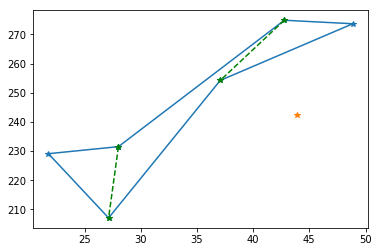

In [476]:
i = 4
print (viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y])
plt.figure()
plt.plot(viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y], '*-')
print (viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'])
plt.plot(viz_file.iloc[i][both_foot_single_join_left_x], viz_file.iloc[i][both_foot_single_join_left_y], '*--', color = 'g')
plt.plot(viz_file.iloc[i][both_foot_single_join_right_x], viz_file.iloc[i][both_foot_single_join_right_y], '*--', color = 'g')
plt.plot(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], '*')
plt.show()

In [36]:
poly_xy = [(x, y) for x, y in zip(viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y])]

In [37]:
is_point_in_path(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], poly_xy)

False

In [437]:
p = asPolygon(poly_xy)
p1 = p.centroid

In [442]:
p1.xy

(array('d', [32.85276633924384]), array('d', [239.985046366188]))

array([43.90015626926846, 242.5276023589361], dtype=object)

In [445]:
np.array(p1)

array([ 32.85276634, 239.98504637])

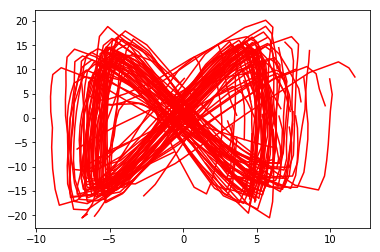

In [41]:
for i in range(len(viz_file[viz_file.EventType=='HSR'])-1):
    limits = range(viz_file[viz_file.EventType=='HSR'].index[i], viz_file[viz_file.EventType=='HSR'].index[i+1]+1)
    plt.figure(1)
    mean_x = viz_file.iloc[limits]['treadmill_COP_x'].mean()
    mean_y = viz_file.iloc[limits]['treadmill_COP_y'].mean()
    plt.plot(viz_file.iloc[limits]['treadmill_COP_x']-mean_x, viz_file.iloc[limits]['treadmill_COP_y']-mean_y, 'r-')
plt.show()

In [98]:
viz_file[viz_file.EventType=='HSR'].index

Int64Index([   0,   37,   73,  108,  141,  174,  207,  239,  271,  302,  334,
             364,  395,  426,  456,  485,  515,  545,  575,  605,  635,  665,
             695,  726,  756,  785,  815,  845,  874,  904,  933,  962,  991,
            1021, 1050, 1078, 1107, 1136, 1165, 1193, 1222, 1250, 1278, 1304,
            1331, 1358, 1385, 1412, 1440, 1468, 1495, 1523],
           dtype='int64')

In [431]:
len(viz_file)

1530

In [99]:
viz_file[viz_file[viz_file.EventType=='HSR'].index[0]:viz_file[viz_file.EventType=='HSR'].index[1]]

,frame_number,Time,EventType,support_type,left toe 1-x,left toe 1-y,left toe 1-conf,left toe 2-x,left toe 2-y,left toe 2-conf,...,right toe 1-y,right toe 1-conf,right toe 2-x,right toe 2-y,right toe 2-conf,right heel-x,right heel-y,right heel-conf,treadmill_COP_x,treadmill_COP_y
0,174,8.798660,HSR,initial DS,28.338049,240.532593,0.695041,20.390447,238.138611,0.705139,...,276.702275,0.619260,50.842480,276.496314,0.613129,39.630913,261.955583,0.509070,39.239220,239.472853
1,175,8.831517,NaN,initial DS,26.475230,238.034313,0.696155,20.254670,235.571413,0.703538,...,276.906947,0.619896,49.931840,275.985777,0.622999,38.863616,260.998522,0.502501,39.775586,238.506069
2,176,8.864374,NaN,initial DS,26.476401,238.032542,0.690571,20.257819,235.573091,0.697692,...,276.694999,0.630604,49.856279,275.868226,0.631578,38.426218,260.991312,0.510657,40.411265,238.355536
3,177,8.897231,NaN,initial DS,28.052194,232.813207,0.678782,20.951137,230.405488,0.707192,...,277.840082,0.595470,49.188310,276.472850,0.597099,38.054712,258.688896,0.447133,41.817108,239.698474
4,178,8.930089,NaN,initial DS,28.006002,231.520070,0.616343,21.774726,229.107303,0.619540,...,274.843349,0.606450,48.863396,273.642274,0.609355,37.068784,254.217909,0.466853,43.900156,242.527602
5,179,8.962946,NaN,initial DS,27.837073,226.419826,0.708336,20.792777,225.233692,0.734767,...,273.260393,0.585218,49.527080,271.275251,0.595420,35.454626,253.587850,0.448144,46.226684,246.840214
6,180,8.995803,NaN,initial DS,21.575483,222.650905,0.474261,26.807302,222.557792,0.441096,...,266.407308,0.379664,43.102848,266.551685,0.368596,30.373458,250.636969,0.269329,48.541622,250.453123
7,181,9.028660,TOL,right SS,29.465649,223.717656,0.736389,22.322243,220.091526,0.724656,...,268.796327,0.587177,49.168008,266.826373,0.595948,31.549096,248.675139,0.465375,50.051306,251.430487
8,182,9.058660,NaN,right SS,27.559866,218.691973,0.757256,21.304491,216.246814,0.766029,...,265.068676,0.578590,47.294895,262.875681,0.581267,26.351551,245.943474,0.481600,50.641114,250.468759
9,183,9.088660,NaN,right SS,26.773843,221.222025,0.706053,20.485847,217.555402,0.716673,...,267.229720,0.682234,52.870284,264.423059,0.708977,26.173830,244.025551,0.464558,50.811773,248.375420


right toe 1-x    45.0863
right toe 2-x    52.8703
right heel-x     26.1738
right toe 1-x    45.0863
Name: 9, dtype: object right toe 1-y     267.23
right toe 2-y    264.423
right heel-y     244.026
right toe 1-y     267.23
Name: 9, dtype: object


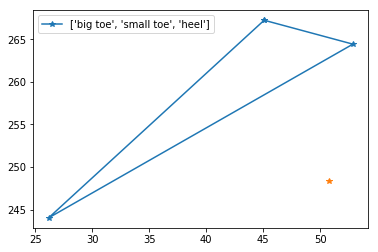

In [12]:
print (viz_file.iloc[9][right_foot_coordinates_x], viz_file.iloc[9][right_foot_coordinates_y])
plt.figure()
plt.plot(viz_file.iloc[9][right_foot_coordinates_x], viz_file.iloc[9][right_foot_coordinates_y], '*-', label = ['big toe', 'small toe', 'heel'])
plt.plot(viz_file.iloc[9]['treadmill_COP_x'], viz_file.iloc[9]['treadmill_COP_y'], '*')
plt.legend()